# Normalizing flows:  re-implementation of the Glow paper

Test latent space interpolations on trained model. The model should be first trained with 
`Celeba48x48_22steps` notebooks. Here we just load weights and do some experiments with latent space variables.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import utils
import nets
import flow_layers as fl

In [7]:
tf.set_random_seed(0)
sess = tf.InteractiveSession()

## Import dataset

In [8]:
batch_size = 8
image_size = 48
x_valid_samples = utils.create_tfrecord_dataset_iterator(
    "datasets/celeba/celeba_valid.tfrecords", batch_size=batch_size, image_size=image_size
)

### Check shapes (initial call will take a while)

In [9]:
x_exampled = x_valid_samples.eval()

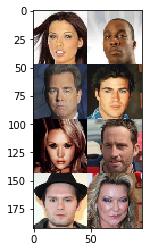

In [10]:
plt.imshow(utils.plot_grid(x_valid_samples).eval())

## Build Flow

This should be exactly the same as trained model, otherwise loading weights will fail.

In [11]:
nn_template_fn = nets.OpenAITemplate(
    width=148
)

In [16]:
x_image_ph = tf.placeholder(tf.float32, [1, image_size, image_size, 3])

In [17]:
layers, actnorm_layers = nets.create_simple_flow(
    num_steps=22, 
    num_scales=3, 
    template_fn=nn_template_fn
)

flow = fl.InputLayer(x_image_ph)
model_flow = fl.ChainLayer(layers)
output_flow = model_flow(flow, forward=True)

QuantizeImage/Forward/                  : x=[1, 48, 48, 3]	z=[None]	logdet=[1]
SqueezingLayer/Forward/Scale1           : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
ActnormBiasLayer/Forward/               : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
ActnormScaleLayer/Forward/              : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
ChainLayer/Forward/                     : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
ActnormLayer/Forward/                   : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
InvertibleConv1x1Layer/Forward/         : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
AffineCouplingLayer/Forward/            : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
ChainLayer/Forward/Step1                : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
ActnormBiasLayer/Forward/               : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
ActnormScaleLayer/Forward/              : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
ChainLayer/Forward/                     : x=[1, 24, 24, 12]	z=[None]	logdet=[1]
ActnormLayer/Forward/                   :

## Prepare output tensors

In [18]:
y, logdet, z = output_flow
output_flow

(<tf.Tensor 'ChainLayer_1/outputs/x:0' shape=(1, 6, 6, 24) dtype=float32>,
 <tf.Tensor 'ChainLayer_1/outputs/lodget:0' shape=(1,) dtype=float32>,
 <tf.Tensor 'ChainLayer_1/outputs/z:0' shape=(1, 6, 6, 168) dtype=float32>)

In [19]:
tfd = tf.contrib.distributions

## Sampling from model

It seems that the best results are obtained when the temperature of the distribution of the Z variable is close 
or equal to zero. 

In [22]:
y_prior_ph = tf.placeholder(tf.float32, y.shape.as_list())
z_prior_ph = tf.placeholder(tf.float32, z.shape.as_list())

logdet_pior_tmp = tf.zeros_like(logdet)

In [23]:
inverse_flow_prim = y_prior_ph, logdet_pior_tmp, z_prior_ph
sampled_flow_prim = model_flow(inverse_flow_prim, forward=False)

FactorOutLayer/Backward/Scale3          : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
AffineCouplingLayer/Backward/           : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
InvertibleConv1x1Layer/Backward/        : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
ActnormScaleLayer/Backward/             : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
ActnormBiasLayer/Backward/              : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
ChainLayer/Backward/                    : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
ActnormLayer/Backward/                  : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
ChainLayer/Backward/Step22              : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
AffineCouplingLayer/Backward/           : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
InvertibleConv1x1Layer/Backward/        : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
ActnormScaleLayer/Backward/             : y=[1, 6, 6, 48]	z=[1, 6, 6, 144]	logdet=[1]
ActnormBiasLayer/Backward/              : y=[1, 6, 6, 

In [24]:
x_flow_sampled_prim, _, _ = sampled_flow_prim

# Load saved model from checkpoint

In [25]:
saver = tf.train.Saver()
saver.restore(sess, "./experiments/celeba48x48_22steps.ckpt")

INFO:tensorflow:Restoring parameters from ./experiments/celeba48x48_22steps.ckpt


### Effect of the temperature on the Z latent variable

In [34]:
y_shape = y_prior_ph.shape.as_list()
z_shape = z_prior_ph.shape.as_list()

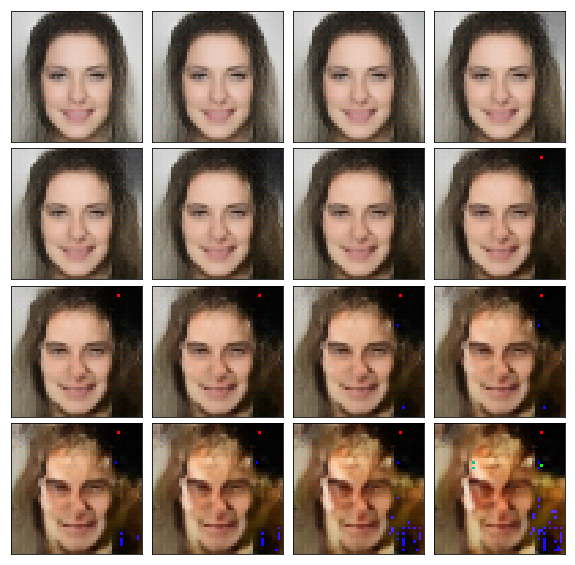

In [54]:
noise_y = np.random.randn(*y_shape)
noise_z = np.random.randn(*z_shape)
images = []
for w in np.linspace(0, 1.5, 16):
    sampled_image = x_flow_sampled_prim.eval({
        y_prior_ph: w*noise_y, 
        z_prior_ph: 0.3*noise_z
    })[0]
    images.append(sampled_image)

images = np.array(images)
utils.plot_4x4_grid(images, images.shape[1:], figsize=(10, 10))

# Interpolation

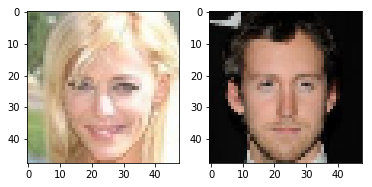

In [60]:
x_example_images = x_valid_samples.eval()
image_a = x_example_images[:1, ...]
image_b = x_example_images[1:2, ...]
plt.subplot(121)
plt.imshow(image_a[0])
plt.subplot(122)
plt.imshow(image_b[0])

In [61]:
latent_y_a, _, latent_z_a = sess.run([y, logdet, z], feed_dict={x_image_ph: image_a})
latent_y_b, _, latent_z_b = sess.run([y, logdet, z], feed_dict={x_image_ph: image_b})

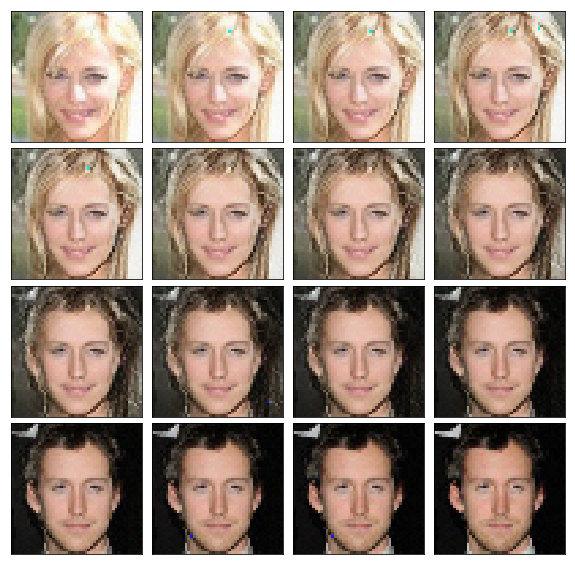

In [62]:
images = []
for w in np.linspace(0, 1.0, 16):
    sampled_image = x_flow_sampled_prim.eval({
        y_prior_ph: (1 - w) * latent_y_a + w * latent_y_b, 
        z_prior_ph: (1 - w) * latent_z_a + w * latent_z_b
    })[0]
    images.append(sampled_image)

images = np.array(images)
utils.plot_4x4_grid(images, images.shape[1:], figsize=(10, 10))